In [2]:
import cv2 as cv
import numpy as np


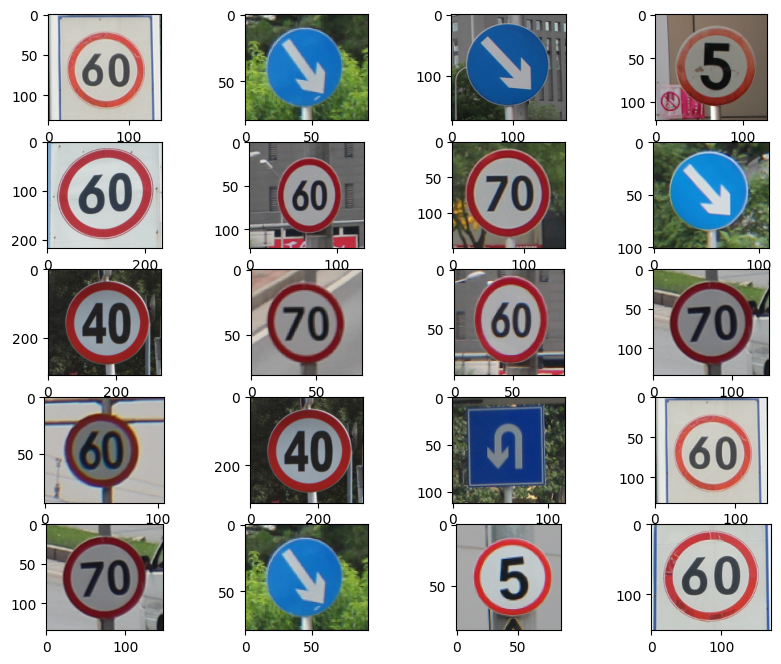

In [3]:
import matplotlib.pyplot as plt
import os

files = np.random.choice(os.listdir("images/"), size=20, replace=True)
img_dir = "images/"

plt.figure(figsize=(10, 8))
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    
plt.show()

In [4]:
import pandas as pd

annotations = pd.read_csv("TsignRecgTrain4170Annotation.txt", sep=";", header=None)
annotations.head()

,0,1,2,3,4,5,6,7,8
0,000_0001.png,134,128,19,7,120,117,0,NaN
1,000_0002.png,165,151,23,12,149,138,0,NaN
2,000_0003.png,128,122,22,14,116,105,0,NaN
3,000_0010.png,80,73,14,8,67,63,0,NaN
4,000_0011.png,186,174,36,15,155,157,0,NaN


In [5]:
img = cv.imread("images/000_0001.png")
img.shape

(128, 134, 3)

In [6]:
annotations.drop([8], axis=1, inplace=True)

In [7]:
annotations.columns = ["filenames", "width", "height", "x_start", "y_start", "x_end", "y_end", "labels"]
annotations.head()

,filenames,width,height,x_start,y_start,x_end,y_end,labels
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


In [8]:
annotations.set_index("filenames", inplace=True)
annotations.head()

,width,height,x_start,y_start,x_end,y_end,labels
filenames,,,,,,,
000_0001.png,134,128,19,7,120,117,0
000_0002.png,165,151,23,12,149,138,0
000_0003.png,128,122,22,14,116,105,0
000_0010.png,80,73,14,8,67,63,0
000_0011.png,186,174,36,15,155,157,0


In [9]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4170 entries, 000_0001.png to 056_1_0054.png
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   width    4170 non-null   int64
 1   height   4170 non-null   int64
 2   x_start  4170 non-null   int64
 3   y_start  4170 non-null   int64
 4   x_end    4170 non-null   int64
 5   y_end    4170 non-null   int64
 6   labels   4170 non-null   int64
dtypes: int64(7)
memory usage: 260.6+ KB


In [10]:
def preprocess_image(img, width, height, blur_ksize=(5, 5)):
    # Resize the image
    resized_img = cv.resize(img, (width, height))
    
    # Denoise the image using Gaussian blur
    denoised_img = cv.GaussianBlur(resized_img, blur_ksize, 0)
    
    # Convert to grayscale
    gray_img = cv.cvtColor(denoised_img, cv.COLOR_BGR2GRAY)
    
    # Convert grayscale to BGR to apply contrast enhancement
    gray_img_bgr = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
    
    # Contrast enhancement
    img_lab = cv.cvtColor(gray_img_bgr, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    L = cv.equalizeHist(L)
    img_lab_merge = cv.merge((L, a, b))
    enhanced_img = cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)
    
    return enhanced_img

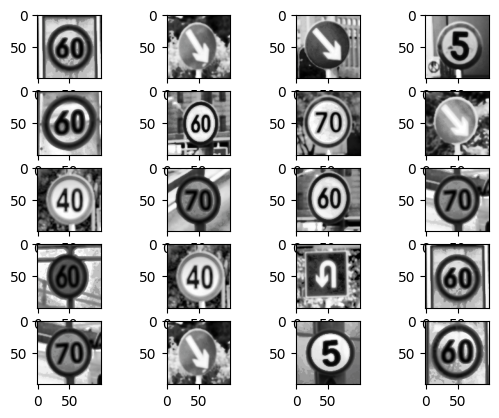

In [11]:
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_rgb =  preprocess_image(img,100,100)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)

In [12]:
# canny edge detection
def auto_canny(img, method, sigma=0.33):
    """
    Args:
    img: grayscale image
    method: Otsu, triangle, and median
    sigma: 0.33 (default)
    2 outputs:
    edge_detection output, the high threshold"""
    if method=="median":
        Th = np.median(img)
        
    elif method=="triangle":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)
        
    elif method=="otsu":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_OTSU)
        
    else:
        raise Exception("method specified not available!")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh), highTh

In [13]:
# Color based segmentation
# Color based segmentation (red, blue, yellow, black)
# Red color
lower_red1 = (0, 40, 50)
upper_red1 = (10, 255, 210)
lower_red2 = (165, 40, 50)
upper_red2 = (179, 255, 210)

# Blue color 
lower_blue = (90, 40, 50)
upper_blue = (120, 255, 210)

# Yellow colors
lower_yellow = (20, 40, 50)
upper_yellow = (35, 255, 210)

# black colors
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_seg(img, kernel_size=None):
    """Args:
    img: image in bgr
    kernel_size: None (default:(3, 3))"""
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask_red1 = cv.inRange(hsv_img, lower_red1, upper_red1)
    mask_red2 = cv.inRange(hsv_img, lower_red2, upper_red2)
    mask_blue = cv.inRange(hsv_img, lower_blue, upper_blue)
    mask_yellow = cv.inRange(hsv_img, lower_yellow, upper_yellow)
    mask_black = cv.inRange(hsv_img, lower_black, upper_black)
    
    mask_combined = mask_red1 | mask_red2 | mask_blue | mask_yellow | mask_black
    
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined

In [14]:
# rectangle detection (using Douglas-Peuker algorithm)
def rect_detect(cnts, coef=0.1):
    """
    Identifies and returns the largest rectangular contour from a list of contours
    
    Args:
    cnts: List of contours detected in an image
    coef: Coefficient to determine the approximation accuracy 
            for contour simplification. Lower values result in 
            more detailed approximations (default is 0.1)
            
    Return:
    numpy.ndarray or None: The largest rectangular contour if found, otherwise None.
    """
    rect_lists = []
    for cnt in cnts:
        if cnt is not None and len(cnt) > 0:
            perimeter = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, coef*perimeter, True)
            if len(approx) == 4:
                rect_lists.append(cnt)
    return max(rect_lists, key=lambda c: cv.contourArea(c)) if rect_lists else None
    
# circle detection
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200, 
    "param2": 15,  
    "minRadius": 10,
    "maxRadius": 100
}
def circle_detect(img, hough_dict):
    """
    Detects circles in a grayscale image using the Hough Circle Transform method.
    
    Args:
    img: Grayscale image in which circles are to be detected.
    hough_dict: hough_circle_transform parameters

    Returns:
    numpy.ndarray or None: The largest circle contour if found, otherwise None.
    """
    mask_circle = np.zeros_like(img)
    circles_detected = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles_detected is not None:
        largest_circle = max(circles_detected[0], key=lambda x: x[2])
        center_x, center_y, radius = largest_circle
        cv.circle(mask_circle, (int(center_x), int(center_y)), int(radius), 255)
        contours_circle, _ = cv.findContours(mask_circle, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        return max(contours_circle, key=lambda c: cv.contourArea(c)) if contours_circle else None
    return None

In [15]:
# combine the results of 2 shape detectors
def combine_shapes(rect_cnt, circle_cnt, cnt):
    """
    Combines and selects the most significant contour from detected rectangles, circles,
    and any additional contours based on their areas.

    Args:
    rect_cnt: The largest rectangular contour detected.
    circle_cnt: The largest circular contour detected.
    cnt: List of additional contours detected in the image.

    Returns:
    numpy.ndarray: The most significant contour (either rectangle, circle, or another contour)
                   based on the largest area. Returns an empty array if no contours are found.
    
    """
    if rect_cnt is not None and circle_cnt is not None:
        if cv.contourArea(circle_cnt) > cv.contourArea(rect_cnt):
            return circle_cnt
        else:
            return rect_cnt
    elif circle_cnt is not None:
        return circle_cnt
    elif rect_cnt is not None:
        return rect_cnt
    elif cnt:
        return max(cnt, key=lambda c: cv.contourArea(c))
    return np.array([])

In [16]:
def combine_edge_color(edges_output, color_output, verbose=False):
    """
    Integrate the results of edge detection and color-based segmentation,
    followed by shape detection to determine the most significant contours.

    Args:
    edges_output: Output from edge detection, should be a list of contours.
    color_output: Output from color-based segmentation, should be a list of contours.
    verbose: Boolean flag for verbosity in output (default is False).

    Returns:
    np.ndarray: The most significant contours from the combined results.
    """
    # Ensure inputs are valid contour lists
    if not isinstance(edges_output, list):
        edges_output = list(edges_output)
        
    if not isinstance(color_output, list):
        color_output = list(color_output)

    if verbose:
        print(f"Contours from edge detection: {len(edges_output)}")
        print(f"Contours from color segmentation: {len(color_output)}")
    
    # Handle cases where both outputs are empty
    if not edges_output and not color_output:
        return np.array([])

    # Sort contours by area in descending order
    edges_output = sorted(edges_output, key=cv.contourArea, reverse=True)
    color_output = sorted(color_output, key=cv.contourArea, reverse=True)

    # Handle cases where only one output is available
    if not edges_output:
        return np.array(color_output)
    
    if not color_output:
        return np.array(edges_output)

    # Combine masks logically if needed (optional)
    # combined_mask = cv.bitwise_or(edges_mask, color_mask)

    # Compare contours based on area and return the more significant one
    if cv.contourArea(edges_output[0]) > cv.contourArea(color_output[0]):
        return np.array(edges_output)
    else:
        return np.array(color_output)

In [17]:
# Calculate the IoU between two bounding boxes
def computeIOU(boxA, boxB):
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [18]:
len(np.array([]))

0

In [48]:
def apply_template_matching(img, templates):
    best_match = None
    highest_score = 0  # Initialize the highest score

    for template in templates:
        res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Keep track of the template with the highest score
        if max_val > highest_score:
            highest_score = max_val
            best_match = {
                "location": max_loc,
                "size": template.shape[::-1],  # Size in (width, height)
                "score": max_val
            }

    return best_match


In [42]:
def load_templates(folder_path):
    """
    Load template images from a specified folder.

    Args:
    folder_path: Path to the folder containing template images.

    Returns:
    List of loaded template images.
    """
    templates = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust the extensions as needed
            template_path = os.path.join(folder_path, filename)
            template = cv.imread(template_path)
            if template is not None:
                templates.append(template)
    return templates

In [51]:
from skimage.exposure import is_low_contrast
from pathlib import Path

img_dir = Path("images")
folder_path = "templates"  # Replace with the path to your folder containing template images
templates = load_templates(folder_path)

IOUs = []
i = 0
fixed_width = 200
files_no_det = []
img_iou_zero = []
for file in img_dir.glob("*.png"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    if img is None:
        print("No such file exists")
        break
    img_copy = img.copy()
    i += 1
    filename = str_fn.split("\\")[-1]
    
    # Denoise the image + change to grayscale
    img_denoised = cv.GaussianBlur(img_copy, (5,5),0)
    if is_low_contrast(img_denoised):
        img_denoised = contrast_enhance(img_denoised)
    # Resize the image
    ratio = fixed_width / img.shape[1]
    img_resized = cv.resize(img_denoised, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)
    
    # change to grayscale
    gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

    #1: Edge detection + shape detection + combine results of shape detector
    edge, canny_th2 = auto_canny(gray, "otsu")

    # Perform shape detectors
    cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    rect_edge = rect_detect(cnt_edge)

    hough_circle_parameters["param1"] = canny_th2
    circle_edge = circle_detect(gray, hough_circle_parameters)

    output1 = combine_shapes(rect_edge, circle_edge, cnt_edge)

    # color segmentation
    color_segmented = color_seg(img_resized)

    # perform rectangular object detection
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = rect_detect(cnt)

    # perform circular object detection
    hough_circle_parameters["param1"] = 200
    circle = circle_detect(color_segmented, hough_circle_parameters)

    output2 = combine_shapes(rect, circle, cnt)
    
    # ground truth bb
    gt_bb = np.array([annotations.loc[filename].x_start, 
                      annotations.loc[filename].y_start,
                      annotations.loc[filename].x_end,
                      annotations.loc[filename].y_end])
    gt_bb = (gt_bb*ratio).astype(int)

    cv.rectangle(img_resized, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    
    # integrate output1 and output2
    combination = combine_edge_color(output1, output2)
    final_output = apply_template_matching(combination, templates)
    if len(final_output) == 0:
        print("no detection!")
        show_img("no detection", img_resized)
        IOUs.append(0)
        files_no_det.append(str_fn)
    else:
        x, y, w, h = cv.boundingRect(final_output)
        cv.rectangle(img_resized, (x, y), (x+w, y+h), (0, 255, 0), 2)

        pred_bb = (x, y, x+w, y+h)

        IOU = computeIOU(gt_bb, pred_bb)

        cv.putText(img_resized, f"IOU: {IOU:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
        IOUs.append(IOU)
        
        if IOU>9:
            img_iou_zero.append(img_resized)
        
        if i % 1000 == 0:
            show_img("results", img_resized)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'cv::matchTemplate'


### Results analysis

In [21]:
IOU_series = pd.Series(IOUs)
IOU_series.describe()

count    101.000000
mean       0.892498
std        0.097079
min        0.572850
25%        0.841782
50%        0.936143
75%        0.965561
max        0.992248
dtype: float64

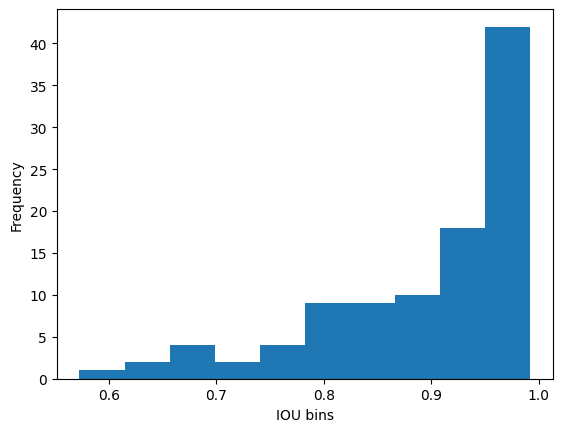

In [22]:
# Histogram
IOU_series.hist()
plt.xlabel("IOU bins"), plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [23]:
len(img_iou_zero)

0

In [24]:
len(files_no_det)

0

In [25]:
arr_IOU = np.array(IOUs)
(arr_IOU>=0.5).sum()

101

In [26]:
print(f"The proportion of good segmentation: {round((arr_IOU>=0.5).sum() / 101, 4)}")

The proportion of good segmentation: 1.0


### Zero IOU images

In [27]:
import random
idx_images = np.arange(len(img_iou_zero))

idx_random_images = np.random.choice(idx_images, 10, replace=False)

fig = plt.figure(figsize=(10, 4))

for i_plot, i_img in enumerate(idx_random_images):
    plt.subplot(2, 5, i_plot+1)
    image = img_iou_zero[i_img]
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
plt.tight_layout()
plt.show()

ValueError: 'a' cannot be empty unless no samples are taken

In [69]:
cv.__version__

'4.10.0'